In [ ]:
import torch
import torch.nn as nn
import math
from typing import List

In [ ]:
dtype = torch.float
device = torch.device("cuda:0")
torch.set_default_device(device)

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self, n_inputs: int, n_hiddens_each_layer: List[int], n_outputs: int):
    """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hiddens_each_layer : List[int]
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """
    super(NeuralNetwork, self).__init__()
    self.n_inputs = n_inputs
    self.n_hiddens_each_layer = n_hiddens_each_layer
    self.n_outputs = n_outputs
    self.standardized = False

    # create list of shapes of weight matrices for each layer
    shapes = self._set_shapes()
    self.shapes = shapes

    # Build one-dimensional weight vector and view into weights
    self.Ws = self._initialize_weights()
    self._validate_weights()

    self.X_means = None
    self.X_stds = None
    self.T_means = None
    self.T_stds = None

    self.n_epochs = 0
    self.error_trace = []

  def _set_shapes(self, W_shapes: List[int]=[]):
    """
    Args:
        W_shapes List[int]: empty list by default, will hold shapes of weights in each layer

    Set shapes for weights in each layer.

    Returns
    -------
    List of pairs of ints: Each pair is the shape of weights in a layer.
    """
    if not self.n_hiddens_each_layer and self.n_outputs <= 0:
      raise ValueError("Network must have at least one hidden layer or valid output units.")

    num_layers = len(self.n_hiddens_each_layer)

    if num_layers >= 1:
        for layer in range(num_layers):
            units_in_layer = self.n_hiddens_each_layer[layer]
            if layer == 0:
                units_prev_layer = self.n_inputs
            else:
                units_prev_layer = self.n_hiddens_each_layer[layer - 1]
            # add 1 to units_prev_layer for constant 1s, second is number of outputs in this layer
            W_shapes.append((1 + units_prev_layer, units_in_layer))
        # shape for output layer
        W_shapes.append((1 + self.n_hiddens_each_layer[-1], self.n_outputs))
    else:
        W_shapes.append((1 + self.n_inputs, self.n_outputs))

    return W_shapes

  def _initialize_weights(self, verbose=False):
      """
      Create weights for each layer using Xavier initialization.

      Returns
      -------
      nn.ParameterList: Trainable weight matrices for each layer.
      """
      if verbose:
          print('Initializing gradients...')
          print(f'Weight Shapes: {self.shapes}')

      Ws = nn.ParameterList()  # Use ParameterList to manage trainable parameters
      for shape in self.shapes:
          n_in, n_out = shape  # Number of inputs and outputs for the layer

          # Xavier scaling factor for uniform distribution
          limit = math.sqrt(6 / (n_in + n_out))
          layer_weight_matrix = torch.empty(n_in, n_out).uniform_(-limit, limit) # Create weight matrix with Xavier initialization

          if torch.isnan(layer_weight_matrix).any() or torch.isinf(layer_weight_matrix).any():
            print(f"Invalid weights for layer with shape {shape}")
            raise ValueError("Weights contain Nan or Inf after initialization.")

          Ws.append(nn.Parameter(layer_weight_matrix))

      return Ws

  def _validate_weights(self):
    for i, weights in enumerate(self.Ws):
      if torch.isnan(weights).any() or torch.isinf(weights).any():
          print(f"NaN or Inf detected in weights of layer {i}")

  def _add_ones(self, X):
        """
        Adds a column of ones to the input matrix X.

        This function inserts a column of ones at the beginning (axis 1) of the input matrix X.
        It is typically used to account for the bias term in the neural network's forward pass.

        Parameters
        ----------
        X : Tensor
            A 2D PyTorch Tensor where each row is a data sample and each column is a feature.

        Returns
        -------
        PyTorch Tensor
            The input tensor X with an additional column of ones inserted at the first position.
            The resulting tensor has a shape of (m, n+1), where m is the number of samples
            and n is the number of features.
        """
        if torch.isnan(X).any() or torch.isinf(X).any():
          print("NaN or Inf detected in input to _add_ones")

        ones_column = torch.ones(X.size(0), 1, device=X.device, dtype=X.dtype)
        result = torch.cat((ones_column, X), dim=1)
        if torch.isnan(result).any() or torch.isinf(result).any():
            print("NaN or Inf detected in output of _add_ones")
        return result

  def forward(self, x):
      """
      In the forward pass we receive a Tensor containing the input and return
      a Tensor containing the output. ctx is a context object that can be used
      to stash information for backward computation. You can cache arbitrary
      objects for use in the backward pass using the ctx.save_for_backward method.
      """
      self.Zs = [x]
      # iterate over all hidden layers
      for weights in self.Ws[:-1]:
        activation = (self._add_ones(self.Zs[-1]) @ weights)
        # add clamping here
        activation = torch.clamp(activation, min=-10, max=10)
        # apply tanh activation function on all hidden layers
        layer_output = torch.tanh(activation)
        self.Zs.append(layer_output)

      # output layer
      Y = self._add_ones(self.Zs[-1]) @ self.Ws[-1]
      self.Zs.append(Y)

      return Y

  def __repr__(self):
      return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_each_layer}, {self.n_outputs})'

In [ ]:
from enum import Enum
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from typing import Optional

class Optimizer(Enum):
  SGD = 1
  ADAMW = 2

class ModelTrainer():
  def __init__(self, optimizer: Optimizer, model: NeuralNetwork, lr=1e-4):
    self.Optimizer = optimizer
    self.model = model
    self.lr = lr
    self.error_trace = []

  def train(
      self,
      model: NeuralNetwork,
      Xtrain: Tensor,
      Ttrain: Tensor,
      Xvalidate: Tensor,
      Tvalidate: Tensor,
      n_epochs: int,
      batch_size: int =-1,
      optimizer: Optional[Optimizer] = Optimizer.SGD,
      learning_rate: Optional[float] = None,
      verbose: bool = True
    ) -> None:
    """
    Trains the neural network model.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network to train.
    Xtrain : torch.Tensor
        Input tensor for training data.
    Ttrain : torch.Tensor
        Target tensor for training data.
    Xvalidate : torch.Tensor
        Input tensor for validation data.
    Tvalidate : torch.Tensor
        Target tensor for validation data.
    n_epochs : int
        Number of training epochs.
    batch_size : int
        Batch size for training. Use -1 for full-batch training.
    optimizer : torch.optim.Optimizer, optional
        Optimizer to use for training.
    learning_rate : float, optional
        Learning rate for the optimizer.
    verbose : bool
        Whether to print progress during training.

    Returns
    -------
    None
    """
    # if batch_size == -1 use all input data as batch
    model.batch_size = batch_size if batch_size != -1 else model.n_inputs

    if model.standardized is False:
      Xtrain, Ttrain, Xvalidate, Tvalidate, model.X_means, model.X_stds, model.T_means, model.T_stds = self._standardize(Xtrain, Ttrain, Xvalidate, Tvalidate)
      model.standardized = True

    # Initialize Optimizers
    optimizer = self._initializeOptimizer()
    loss_fn = torch.nn.MSELoss(reduction='mean')

    train_ds = TensorDataset(Xtrain, Ttrain)
    valid_ds = TensorDataset(Xvalidate, Tvalidate)
    train_dl, valid_dl = self.get_data(train_ds, valid_ds, model.batch_size)
    self.fit(n_epochs, model, loss_fn, optimizer, train_dl, valid_dl)

    print("Finished training run!")

  def fit(self, n_epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(n_epochs):
      model.train() # set to train mode
      train_total_loss, train_samples = 0.0, 0
      for X_batch, T_batch in train_dl:
        train_batch_loss, train_batch_size = self.loss_batch(model, loss_fn, X_batch, T_batch, opt=opt)
        train_total_loss += train_batch_loss * train_batch_size
        train_samples += train_batch_size
      train_loss = train_total_loss / train_samples

      # eval model against Validation data
      model.eval()  # Set model to evaluation mode
      with torch.no_grad():  # No need to compute gradients during validation
          total_loss, total_samples = 0.0, 0
          for X_batch, T_batch in valid_dl:
              batch_loss, batch_size = self.loss_batch(model, loss_fn, X_batch, T_batch)
              total_loss += batch_loss * batch_size
              total_samples += batch_size
      val_loss = total_loss / total_samples
      self.error_trace.append((train_loss, val_loss))

      if n_epochs >= 0 and epoch % (n_epochs // 10) == 0:
        print(f"Epoch: {epoch}, Train loss: {train_loss}, Val Loss: {val_loss}")

  def loss_batch(self, model, loss_func, xb, tb, opt=None):
    loss = loss_func(model(xb), tb)

    if opt is not None:
      # Zero gradients, perform a backward pass, and update the weights.
      loss.backward()
      opt.step()
      opt.zero_grad()

    return loss.item(), len(xb)

  def get_data(self, train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, generator=torch.Generator(device='cuda')),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

  def _standardize(self, Xtrain, Ttrain, Xvalidate, Tvalidate):
      # Calculate and assign standardization parameters
      X_means = torch.mean(Xtrain, dim=0)
      X_stds = torch.std(Xtrain, dim=0)
      X_stds[X_stds == 0] = 1  # Prevent division by zero

      T_means = torch.mean(Ttrain, dim=0)
      T_stds = torch.std(Ttrain, dim=0)
      T_stds[T_stds == 0] = 1  # Prevent division by zero

      # Standardize data
      Xtrain_std = (Xtrain - X_means) / X_stds
      Ttrain_std = (Ttrain - T_means) / T_stds
      Xvalidate_std = (Xvalidate - X_means) / X_stds
      Tvalidate_std = (Tvalidate - T_means) / T_stds

      return Xtrain_std, Ttrain_std, Xvalidate_std, Tvalidate_std, X_means, X_stds, T_means, T_stds

  def _initializeOptimizer(self):
    if self.Optimizer == Optimizer.SGD:
      optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)
    elif self.Optimizer == Optimizer.ADAMW:
      optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
    else:
      raise ValueError(f"Unsupported optimizer type: {self.Optimizer}")

    return optimizer

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.linspace(0, 10, 200).reshape(-1, 1)
T = np.sin(X)

# Split into training and validation sets
X, X_val, T, T_val = train_test_split(X, T, test_size=0.2, random_state=42)

# Print shapes to verify split
print(f"Training set: X_train {X.shape}, T_train {T.shape}")
print(f"Validation set: X_val {X_val.shape}, T_val {T_val.shape}")

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
T_tensor = torch.tensor(T, dtype=torch.float32)
Xval_tensor = torch.tensor(X_val, dtype=torch.float32)
Tval_tensor = torch.tensor(T_val, dtype=torch.float32)

X_tensor.shape, T_tensor.shape, Xval_tensor.shape, Tval_tensor.shape

Training set: X_train (160, 1), T_train (160, 1)
Validation set: X_val (40, 1), T_val (40, 1)


(torch.Size([160, 1]),
 torch.Size([160, 1]),
 torch.Size([40, 1]),
 torch.Size([40, 1]))

In [ ]:
nnet = NeuralNetwork(X.shape[1], [20, 20, 10], 1)
trainer = ModelTrainer(Optimizer.SGD, nnet, 0.001)
trainer.train(nnet, X_tensor, T_tensor, Xval_tensor, Tval_tensor, n_epochs=150, batch_size=100)

Epoch: 0, Train loss: 1.025652676820755, Val Loss: 0.8136724829673767
Epoch: 15, Train loss: 1.0069014728069305, Val Loss: 0.8187220692634583
Epoch: 30, Train loss: 0.9940111935138702, Val Loss: 0.8253135681152344
Epoch: 45, Train loss: 0.9851004779338837, Val Loss: 0.8316842317581177
Epoch: 60, Train loss: 0.9784286916255951, Val Loss: 0.8377314805984497
Epoch: 75, Train loss: 0.9727732688188553, Val Loss: 0.8439966440200806
Epoch: 90, Train loss: 0.9688079059123993, Val Loss: 0.8481042981147766
Epoch: 105, Train loss: 0.9654664993286133, Val Loss: 0.8522607684135437
Epoch: 120, Train loss: 0.962760902941227, Val Loss: 0.8549535870552063
Epoch: 135, Train loss: 0.960203006863594, Val Loss: 0.8567686080932617
Finished training run!


In [ ]:
nnet.Ws

ParameterList(
    (0): Parameter containing: [torch.float32 of size 2x20 (cuda:0)]
    (1): Parameter containing: [torch.float32 of size 21x20 (cuda:0)]
    (2): Parameter containing: [torch.float32 of size 21x10 (cuda:0)]
    (3): Parameter containing: [torch.float32 of size 11x1 (cuda:0)]
)

In [ ]:
# no need for inference()/use() functions when our NeuralNet class
# inherits torch.nn.Module. Can call forward function with the class instance itself
nnet(X_tensor)

tensor([[-0.0495],
        [-0.1157],
        [-0.0380],
        [-0.0483],
        [-0.0781],
        [-0.1149],
        [-0.0438],
        [-0.0528],
        [-0.0903],
        [-0.0542],
        [-0.0731],
        [-0.1054],
        [-0.0539],
        [-0.0805],
        [-0.0750],
        [-0.0456],
        [-0.0886],
        [-0.0624],
        [-0.1049],
        [-0.0611],
        [-0.1035],
        [-0.0617],
        [-0.0422],
        [-0.0568],
        [-0.0395],
        [-0.0762],
        [-0.0366],
        [-0.1124],
        [-0.0569],
        [-0.0864],
        [-0.0362],
        [-0.0811],
        [-0.1001],
        [-0.0369],
        [-0.0756],
        [-0.0724],
        [-0.0465],
        [-0.0881],
        [-0.0638],
        [-0.0711],
        [-0.0495],
        [-0.0482],
        [-0.0360],
        [-0.1116],
        [-0.1133],
        [-0.0535],
        [-0.0996],
        [-0.0390],
        [-0.1128],
        [-0.0392],
        [-0.0502],
        [-0.0892],
        [-0.

# More Detailed Example Use

In [ ]:
# init train data as Pytorch Tensors
Xtrain = torch.arange(-2, 2, 0.05).reshape(-1, 1)
Ttrain = torch.sin(Xtrain) * torch.sin(Xtrain * 5)
# Validation data
Xval = Xtrain * 1.1
Tval = Ttrain + 0.2 * Xtrain
# Test data
Xtest = Xtrain * 0.97
Ttest = Ttrain + 0.15 * Xtrain

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

(torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([80, 1]))

In [ ]:
import matplotlib.pyplot as plt

nnet = NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
trainer = ModelTrainer(Optimizer.SGD, nnet, 0.001)
trainer.train(nnet, Xtrain, Ttrain, Xval, Tval, n_epochs=1000, batch_size=-1)

Epoch: 0, Train loss: 1.153131844091058, Val Loss: 1.2313922978413756
Epoch: 100, Train loss: 0.8789210948503751, Val Loss: 1.0310044342651963
Epoch: 200, Train loss: 0.6280863240747749, Val Loss: 0.9294937088619918
Epoch: 300, Train loss: 0.6182256180909462, Val Loss: 0.922134662931785
Epoch: 400, Train loss: 0.6001902441909805, Val Loss: 0.9024488654918968
Epoch: 500, Train loss: 0.4378193076823663, Val Loss: 0.6745024447329342
Epoch: 600, Train loss: 0.32910485645470544, Val Loss: 0.5915147294523194
Epoch: 700, Train loss: 0.3100053051664872, Val Loss: 0.6391217289841734
Epoch: 800, Train loss: 0.4384468462527821, Val Loss: 0.6451249355974141
Epoch: 900, Train loss: 0.2791620700409226, Val Loss: 0.47623373444657774
Finished training run!


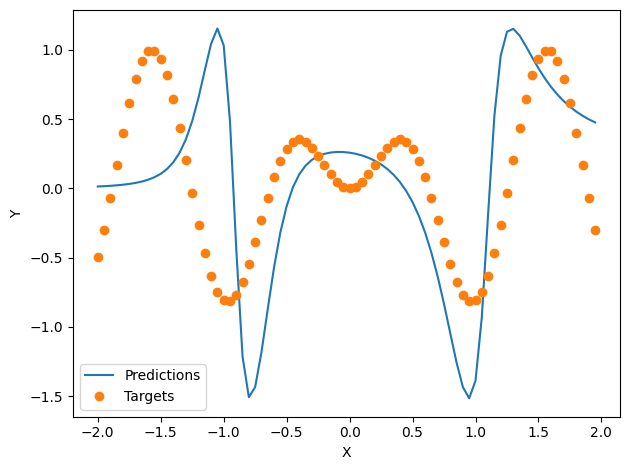

In [ ]:
Ytrain = nnet(Xtrain)
plt.plot(Xtrain.cpu().detach().numpy(), Ytrain.cpu().detach().numpy(), '-', label='Predictions')
plt.plot(Xtrain.cpu().detach().numpy(), Ttrain.cpu().detach().numpy(), 'o', label='Targets')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.tight_layout()

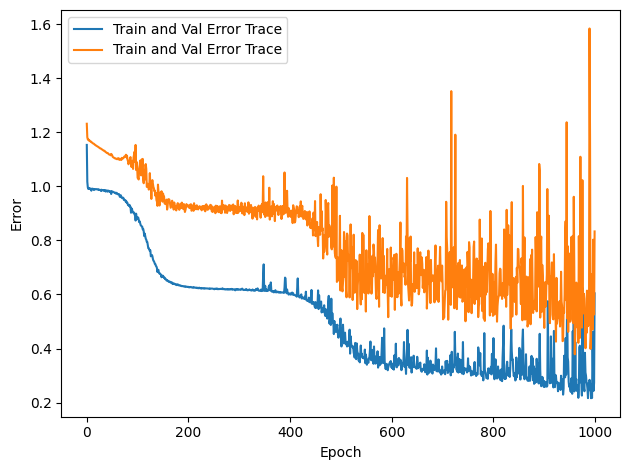

In [ ]:
# Extract training and validation errors
train_errors = [entry[0] for entry in trainer.error_trace]
val_errors = [entry[1] for entry in trainer.error_trace]

# Plot the errors
plt.plot(train_errors, label="Training Error")
plt.plot(val_errors, label="Validation Error")

# Add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training and Validation Error")
plt.legend()

## Apply NeuralNetwork PyTorch Implementation to MNIST dataset

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [ ]:
# load mnist data form pickle format
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


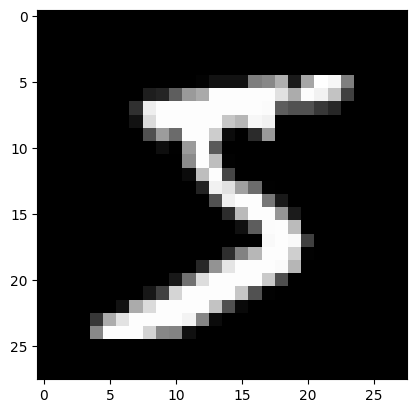

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

In [ ]:
# convert input data from numpy arrays to torch tensors
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0') tensor([5, 0, 4,  ..., 8, 4, 8], device='cuda:0')
torch.Size([50000, 784])
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
